# Week 5 Assignment -- Random Forest Classifiers with Hyperparameter Tuning (RandomizedSearchCV() and GridSearchCV())

**REQUIREMENTS**
1.  Conduct your analysis using a cross-validation design.
2.  Conduct / improve upon previous EDA.
3.  Build the following models at a minimum.

> *   Random Forest Classifier
*   Gradient Boosted Tree
*   Extra Trees

4.  Conduct hyperparameter tuning for the following at a minimum.

> *   n_estimators (number of trees)
*   max_features (maximum features considered for splitting a node)
*   max_depth (maximum number of levels in each tree)
*   splitting criteria (entropy or gini)
   
5.   Compare your models using the F1-Score on a 20% validation set.
6.   Generate predictions from your models. (Since there is no active competition on Kaggle.com, this requirement was essentially performed using the validation set in #5 above.)

#INGRESS

In [1]:
# import libraries
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
#import statsmodels.api as sm
import math
import random

from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure

#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import zero_one_loss

#from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import confusion_matrix

import pylab
from pylab import hist, show, xticks
#from sklearn.cluster import KMeans
#from scipy.spatial.distance import cdist
#from scipy import optimize
#from scipy import interpolate
#from numpy.linalg import lstsq
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from pprint import pprint

In [2]:
# get training data
from google.colab import files
upload = files.upload()

Saving data.csv to data.csv


In [3]:
origDF = pd.read_csv('data.csv')

In [4]:
# extract the response variable 'Bankrupt?' and based upon previous EDA in Assginment 4,
#   remove variables deemed to be redundant (high correlation with other variable)
#   and/or not highly correlated with response variable 'Bankrupt?'
y = origDF['Bankrupt?']
smallDF = origDF.drop(columns=[' Net Income Flag', ' Quick Assets/Current Liability',
                        ' Revenue Per Share (Yuan ¥)', ' Current Ratio',
                        ' Cash Flow to Sales', ' Total income/Total expense',
                        ' Total Asset Turnover', ' Operating Profit Rate',
                        ' Operating profit per person', ' Accounts Receivable Turnover',
                        ' Total Asset Growth Rate', ' Allocation rate per person',
                        ' Average Collection Days', ' Net Value Growth Rate',
                        ' Current Liabilities/Liability', ' Current Liabilities/Equity',
                        ' Realized Sales Gross Margin', ' ROA(A) before interest and % after tax',
                        ' ROA(B) before interest and depreciation after tax',
                        ' Operating profit/Paid-in capital',' Operating Profit Per Share (Yuan ¥)',
                        ' Debt ratio %', ' Per Share Net profit before tax (Yuan ¥)',
                        ' ROA(C) before interest and depreciation before interest',
                        ' Retained Earnings to Total Assets', ' Pre-tax net Interest Rate',
                        ' Net Value Per Share (C)', ' Borrowing dependency',
                        ' Regular Net Profit Growth Rate',' Current Liability to Assets',
                        ' Contingent liabilities/Net worth', ' Current Assets/Total Assets',
                        ' Current Liability to Equity', ' Cash flow rate', ' Net Value Per Share (B)',
                        ' Inventory/Current Liability',' Persistent EPS in the Last Four Seasons',
                        ' Liability to Equity',' Net Income to Total Assets',' Revenue per person',
                        ' Operating Gross Margin',' Continuous interest rate (after tax)',
                        ' Cash Flow Per Share',' Cash Reinvestment %',
                        ' Current Liability to Current Assets', ' Quick Assets/Total Assets',
                        ' Equity to Liability',' Equity to Long-term Liability',
                        ' Working capitcal Turnover Rate'," Net Income to Stockholder's Equity",
                        ' Operating Profit Growth Rate',' Cash/Total Assets',
                        ' Net Value Per Share (A)',' Cash Flow to Equity',' Operating Profit Growth Rate',
                        ' Operating Funds to Liability', ' Cash Flow to Liability',
                        ' Interest Coverage Ratio (Interest expense to EBIT)',
                        ' Continuous Net Profit Growth Rate',' Inventory Turnover Rate (times)',
                        ' Operating Expense Rate',' Interest Expense Ratio',
                        ' Long-term Liability to Current Assets',
                        ' Realized Sales Gross Profit Growth Rate',' After-tax net Interest Rate',
                        ' No-credit Interval',' Inventory/Working Capital'], axis=1)

print('The original number of columns in the data is', len(origDF.columns))
print('\nAfter removing Bankrupt? and insignificant or correlated explanatory variables,')
print('  the number of columns in the reduced dataframe is', len(smallDF.columns))

The original number of columns in the data is 96

After removing Bankrupt? and insignificant or correlated explanatory variables,
  the number of columns in the reduced dataframe is 30


In [7]:
# Min max scale the explanatory variables

# create Min-Max funcion
def min_max_scale(df):
  mins = df.min()
  maxs = df.max()
  ranges = maxs-mins
  if ranges==0:
    ranges = 1
  return (df - mins)/ranges

# use apply() to min-max all columns except 'Bankrupt?' response variable
minMaxDF = smallDF.copy()
#variableList = ['Liability Assets Flag']  # this variable is already (0/1)
variableList = []
minMaxDF = minMaxDF.apply(lambda x: min_max_scale(x) if x.name not in variableList else x)

In [ ]:
# check for missing data
pd.set_option('display.max_rows', None)  # display all the results
minMaxDF.isnull().sum()

Bankrupt?                                       0
 Non-industry income and expenditure/revenue    0
 Research and development expense rate          0
 Interest-bearing debt interest rate            0
 Tax rate (A)                                   0
 After-tax Net Profit Growth Rate               0
 Total Asset Return Growth Rate Ratio           0
 Quick Ratio                                    0
 Total debt/Total net worth                     0
 Net worth/Assets                               0
 Long-term fund suitability ratio (A)           0
 Net profit before tax/Paid-in capital          0
 Inventory and accounts receivable/Net value    0
 Fixed Assets Turnover Frequency                0
 Net Worth Turnover Rate (times)                0
 Working Capital to Total Assets                0
 Cash/Current Liability                         0
 Working Capital/Equity                         0
 Total expense/Assets                           0
 Current Asset Turnover Rate                    0


In [8]:
# extract the column names
allVariableNames = tuple(minMaxDF.columns)
explanNames = list(allVariableNames[1:])
nExplan = len(explanNames)
print('There are', nExplan, 'explanatory variables')

There are 29 explanatory variables


In [ ]:
# inspect columns
pd.set_option('display.max_columns', None)  # display all the columns
minMaxDF.head(10)

,Bankrupt?,Non-industry income and expenditure/revenue,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),After-tax Net Profit Growth Rate,Total Asset Return Growth Rate Ratio,Quick Ratio,Total debt/Total net worth,Net worth/Assets,Long-term fund suitability ratio (A),Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Working Capital to Total Assets,Cash/Current Liability,Working Capital/Equity,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Current Liability to Liability,Cash Flow to Total Assets,CFO to Assets,Liability-Assets Flag,Total assets to GNP price,Gross Profit to Sales,Degree of Financial Leverage (DFL)
0,1.0,0.302646,0.000000,7.323965e-13,0.000000,0.688979,0.263100,1.308510e-13,2.139429e-12,0.792424,0.005024,0.137757,0.398036,1.166173e-14,0.032903,0.672775,1.526798e-14,0.721275,0.064856,7.010000e-02,6.550000e-01,4.580000e-02,5.098627e-11,0.676269,0.637555,0.520382,0.0,9.388432e-13,0.601453,0.026601
1,1.0,0.303556,0.000000,6.536007e-13,0.000000,0.689693,0.264516,4.376345e-13,1.257786e-12,0.828824,0.005059,0.168962,0.397725,7.197197e-02,0.025484,0.751111,1.434104e-13,0.731975,0.025516,1.065198e-14,7.700000e-01,2.490000e-01,5.634953e-11,0.308589,0.641100,0.567101,0.0,8.475867e-13,0.610237,0.264577
2,1.0,0.302035,0.002555,7.980596e-13,0.000000,0.689463,0.264184,5.793673e-13,2.137594e-12,0.792484,0.005100,0.148036,0.406580,2.652653e-01,0.013387,0.829502,5.533679e-01,0.742729,0.021387,1.791094e-13,1.022676e-13,7.610000e-02,3.319462e-11,0.446027,0.642765,0.538491,0.0,4.073610e-12,0.601449,0.026555
3,1.0,0.303350,0.000000,4.535807e-13,0.000000,0.689110,0.263371,3.138127e-13,9.630183e-13,0.848535,0.005047,0.147561,0.397925,9.159159e-01,0.028065,0.725754,1.047302e-13,0.729825,0.024161,8.140000e-01,6.050000e-01,2.030000e-01,6.720480e-11,0.615848,0.579039,0.604105,0.0,3.312093e-13,0.583538,0.026697
4,1.0,0.303475,0.000000,6.929986e-13,0.000000,0.689697,0.265218,4.038404e-13,5.180684e-13,0.893491,0.005303,0.167461,0.400079,2.938149e-14,0.040161,0.751822,7.051436e-14,0.732000,0.026385,6.680000e-01,5.050000e-01,8.240000e-02,3.720612e-11,0.975007,0.622374,0.578469,0.0,3.948639e-13,0.598782,0.024752
5,1.0,0.303116,0.000000,7.233047e-13,0.000000,0.689105,0.263250,9.259603e-14,1.429895e-12,0.819573,0.004913,0.137825,0.400419,9.309309e-01,0.029677,0.686729,1.045143e-14,0.725202,0.040094,8.010000e-01,2.810000e-01,2.950000e-02,7.249922e-11,0.733352,0.637470,0.622190,0.0,5.374618e-13,0.590172,0.026675
6,0.0,0.302814,0.073146,8.132126e-13,0.000000,0.688590,0.263032,3.108388e-13,2.458875e-12,0.783898,0.005005,0.127939,0.400574,1.453930e-14,0.040806,0.729416,1.088406e-13,0.728731,0.092802,1.058011e-14,9.560000e-01,2.390000e-01,4.277089e-11,0.508089,0.630419,0.560653,0.0,1.870863e-12,0.619949,0.026622
7,0.0,0.303545,0.005100,6.364273e-13,0.157607,0.689535,0.264112,7.913919e-13,5.310041e-13,0.891798,0.005640,0.179519,0.400883,5.187197e-14,0.046290,0.797005,9.203337e-14,0.734946,0.025482,7.290000e-01,6.180000e-01,7.340000e-02,2.625882e-11,0.755770,0.641553,0.610091,0.0,1.018789e-12,0.601739,0.027031
8,0.0,0.303584,0.000000,7.445189e-13,0.005871,0.689924,0.264151,1.280934e-12,2.279795e-13,0.941409,0.005418,0.172159,0.397462,2.461079e-14,0.029516,0.813738,1.366862e-12,0.735182,0.029884,1.026722e-14,9.840000e-01,1.052297e-14,3.892564e-11,0.906707,0.649869,0.574033,0.0,8.391764e-14,0.603613,0.026891
9,0.0,0.303483,0.000000,6.788558e-13,0.392449,0.689338,0.263883,8.143720e-13,6.392599e-13,0.878707,0.005475,0.175658,0.406363,7.390809e-14,0.076613,0.825696,5.086875e-14,0.737180,0.035891,5.110000e-01,3.600000e-01,2.580000e-02,3.064343e-11,0.734899,0.643428,0.645146,0.0,5.903913e-13,0.599205,0.027243


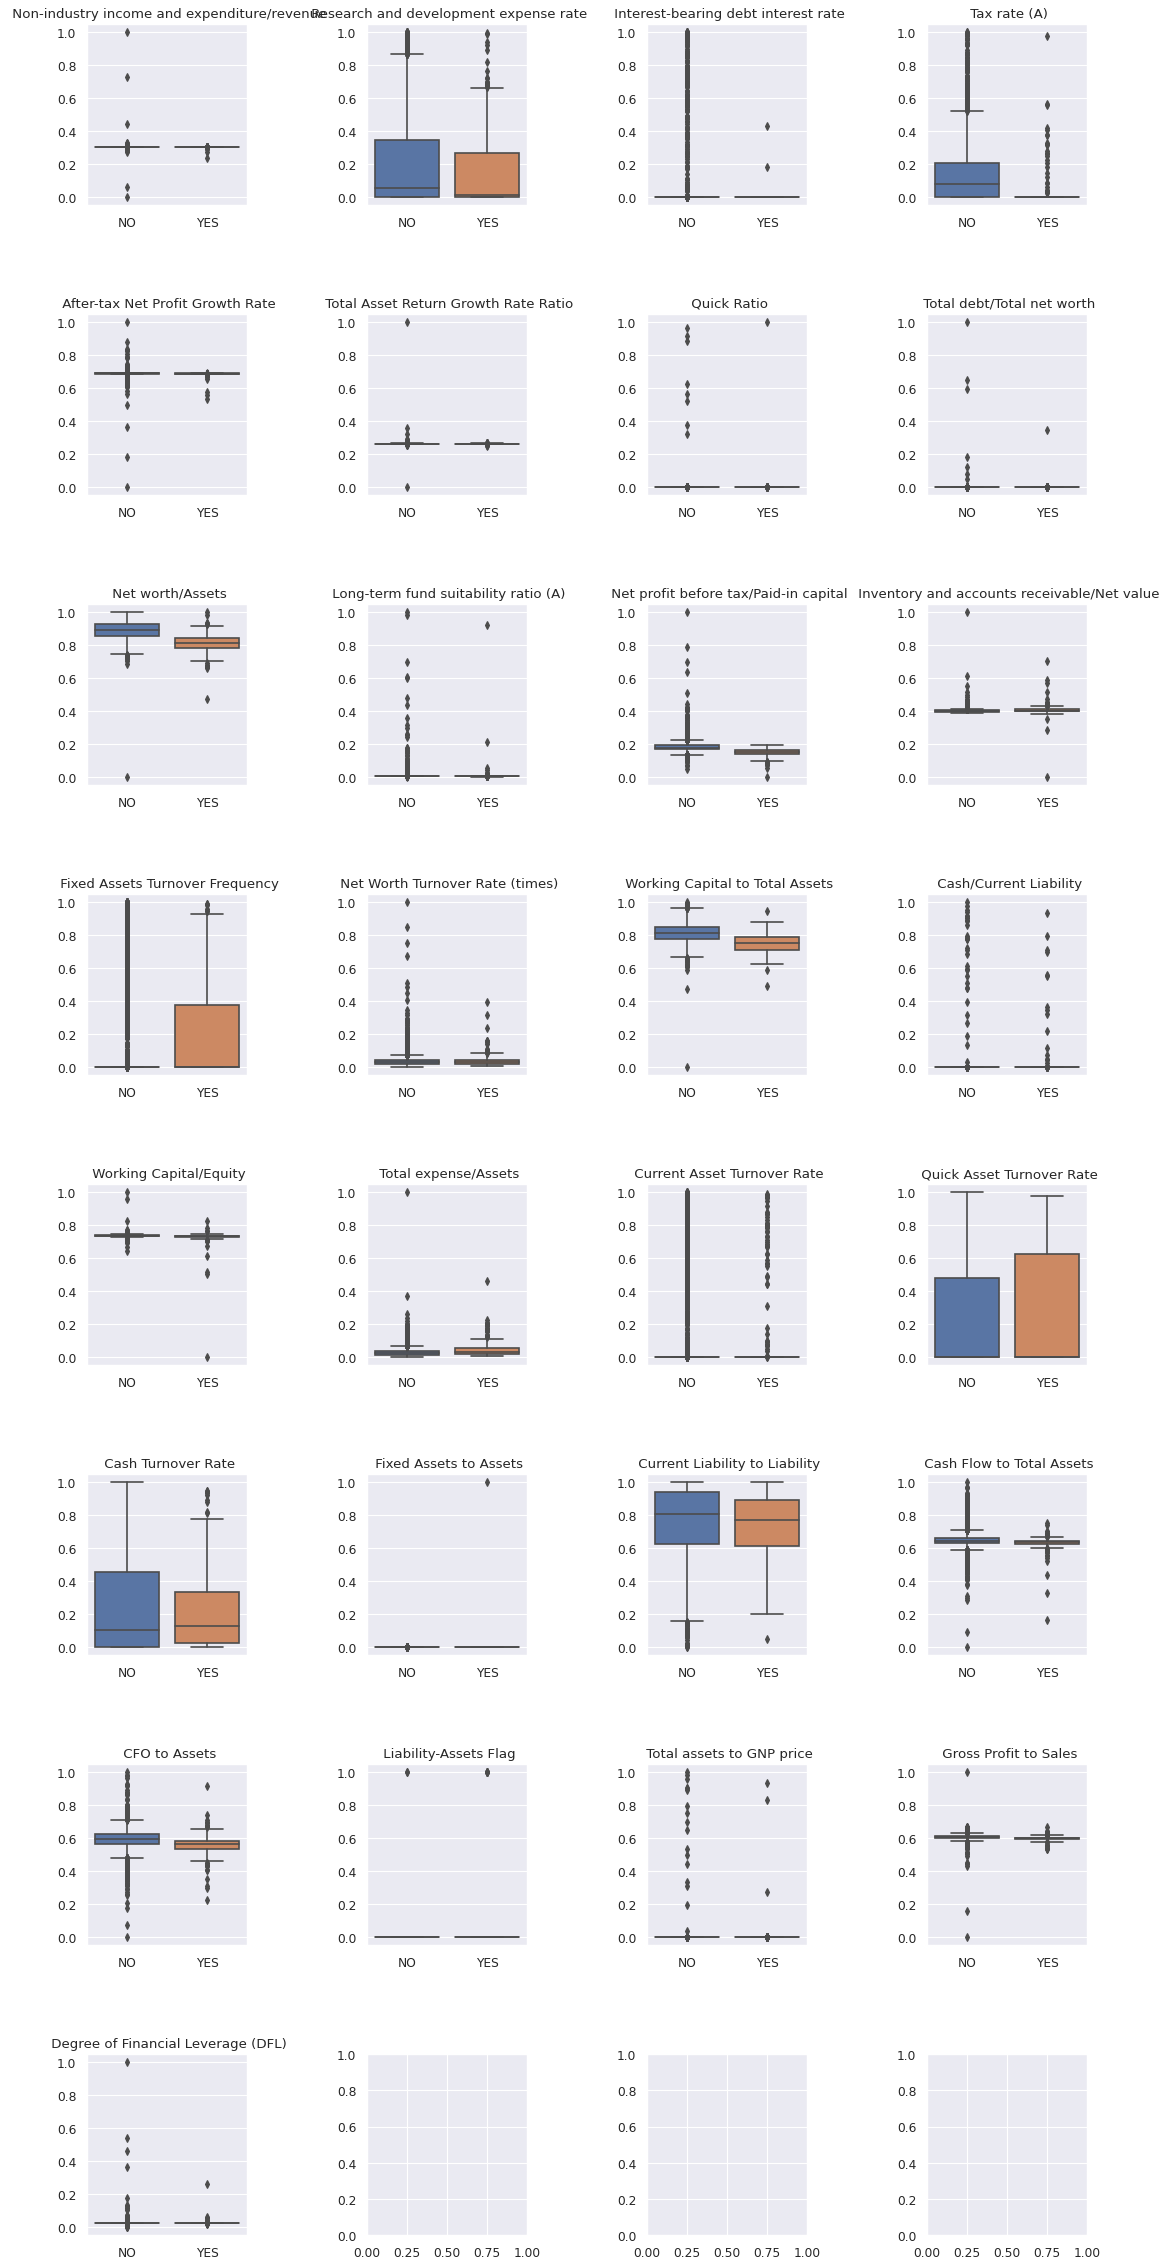

In [ ]:
# generate box plots to view how the distribution of each variable corresponds to bankruptcy (0=NO; 1=YES)

# using Matplotlib subplots with Seaborn boxplots
sns.set() # set seaborn as default style even if use only matplotlib

N_PLT_COLS = 4    # set this value (a divisor of the number of explanatory variables nExplan)
nPltRows = math.ceil(nExplan/N_PLT_COLS)

fig, axs = plt.subplots(nrows=nPltRows, ncols=N_PLT_COLS, figsize=(15,30), dpi=80)
fig.tight_layout(pad=6.0)

#sns.set(font_scale = 1)  # reset font scale

rowIndex = 0
colIndex = 0

noDF = minMaxDF[minMaxDF['Bankrupt?'] == 0]
yesDF = minMaxDF[minMaxDF['Bankrupt?'] != 0]

for aa in range(nExplan):

  explanVariable = explanNames[aa]
  noData = list(noDF[explanVariable])
  yesData = list(yesDF[explanVariable])
  yesAndNoData = [noData, yesData]

  sns.boxplot(ax=axs[rowIndex,colIndex], data=yesAndNoData)
  #axs[rowIndex,colIndex].boxplot(yesAndNoData)
  axs[rowIndex,colIndex].set_xticklabels(['NO', 'YES'])
  axs[rowIndex,colIndex].title.set_text(explanVariable)
 
  # increment column (and possibly row) index
  colIndex += 1
  if colIndex == N_PLT_COLS:
    rowIndex += 1
    colIndex = 0

  if rowIndex == nPltRows:
    if colIndex == nExplan % N_PLT_COLS:
      break

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

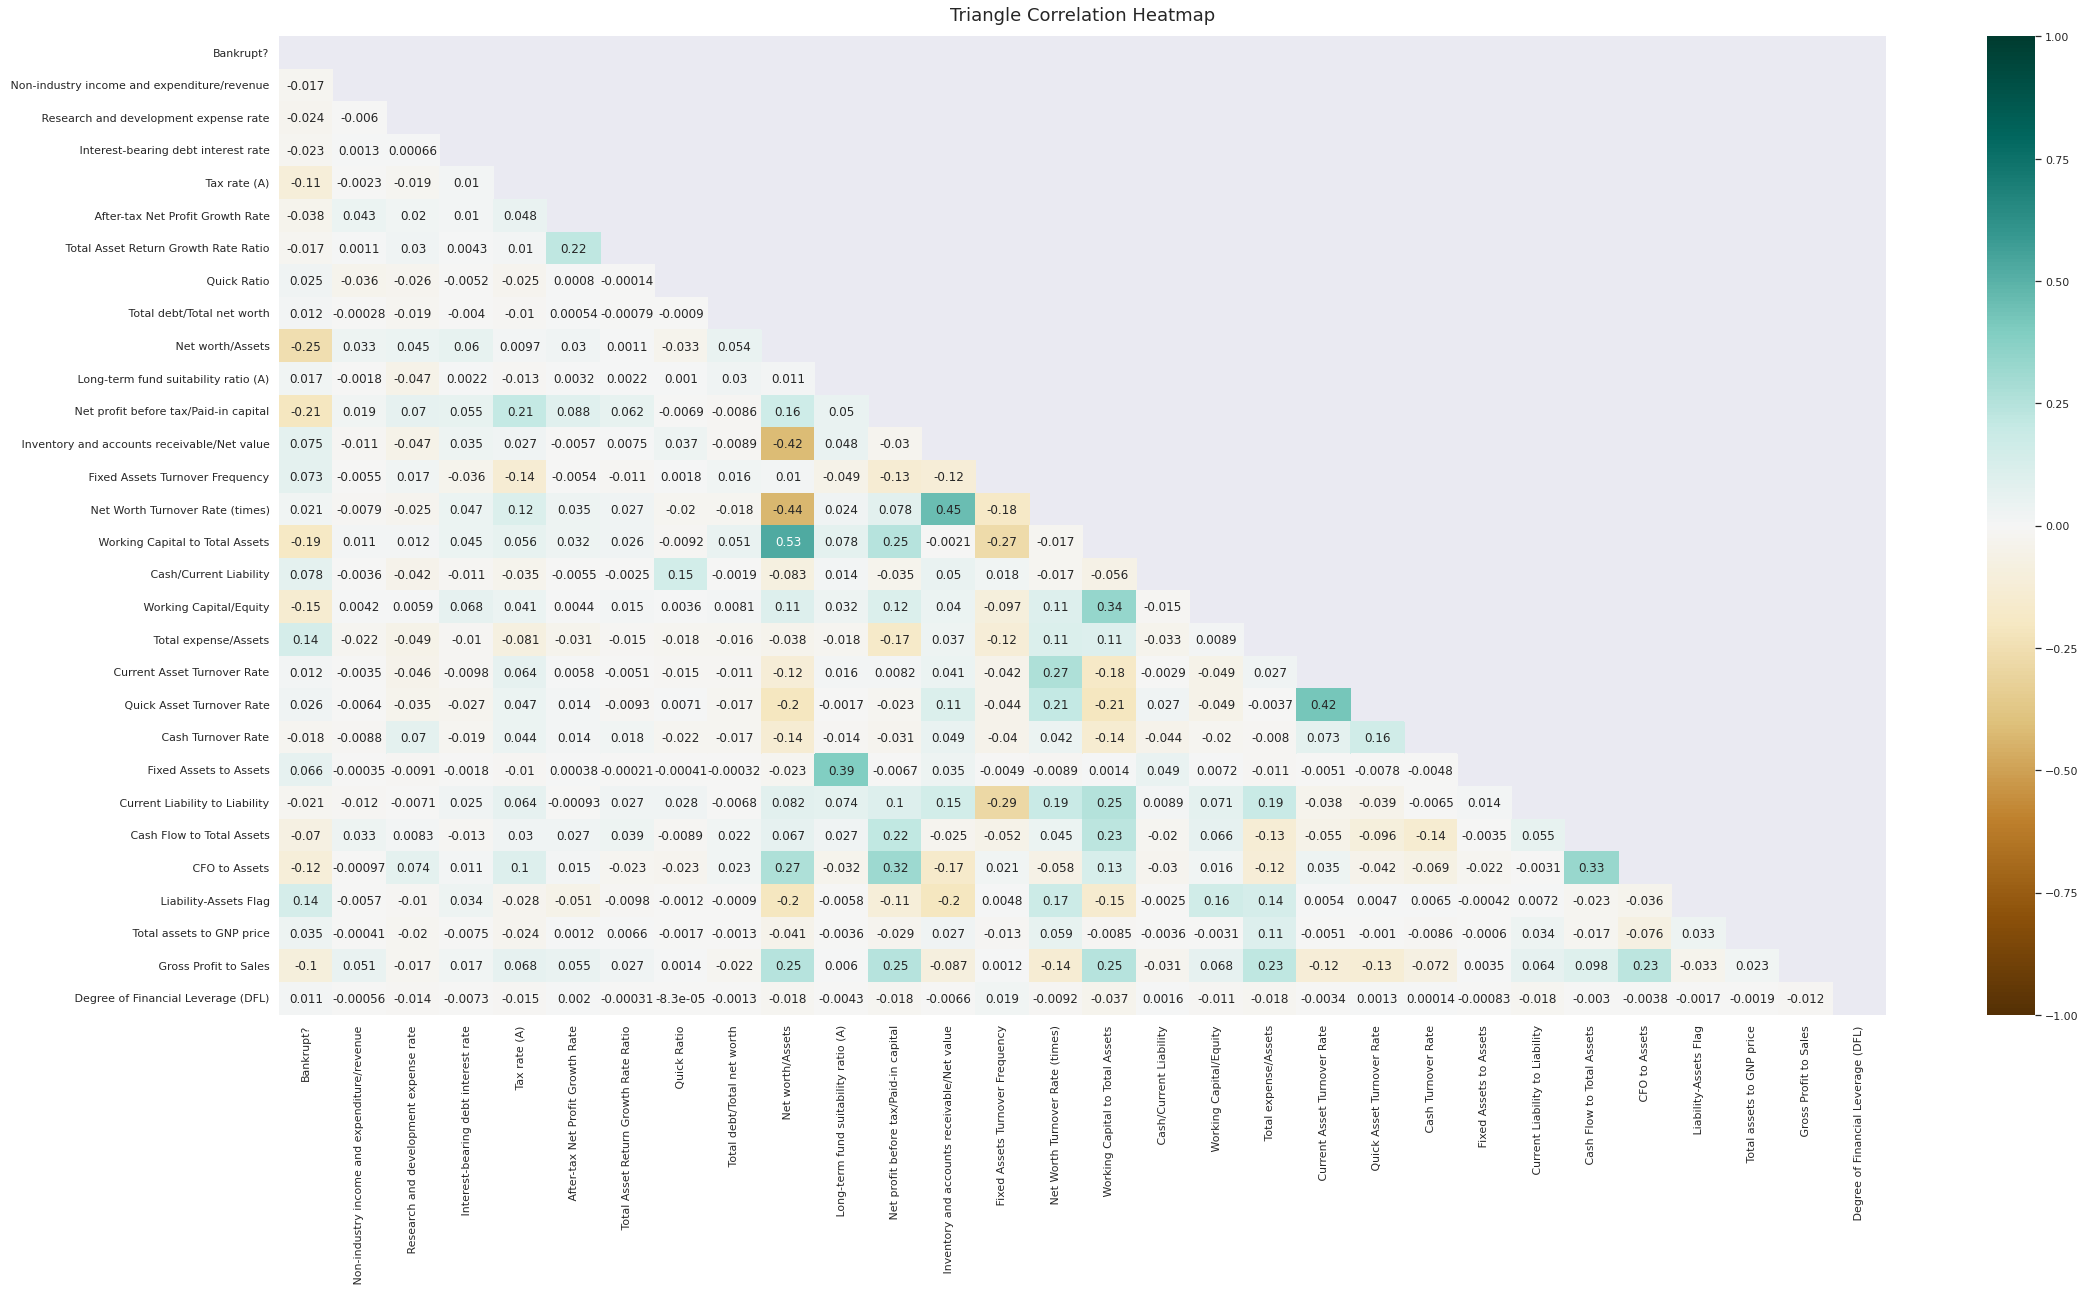

In [ ]:
plt.figure(figsize=(36, 18))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(minMaxDF.corr(), dtype=bool))
heatmap = sns.heatmap(minMaxDF.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

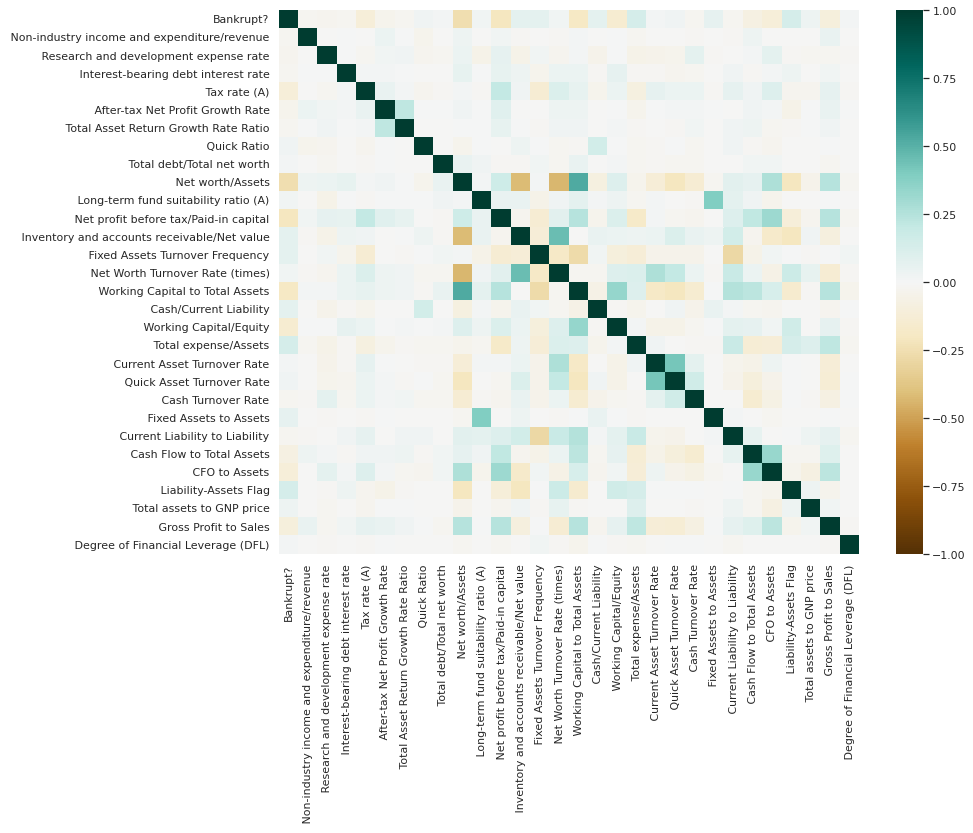

In [ ]:
# perhaps easier to visualize correlations as full map and without correlation numbers
sns.set(font_scale = 1)  # set font scale
plt.figure(figsize=(13, 10))
sns.heatmap(minMaxDF.corr(),
              xticklabels=minMaxDF.columns,
              yticklabels=minMaxDF.columns,
              vmin=-1, vmax=1, annot=False, cmap='BrBG')
sns.set(font_scale = 1)  # reset font scale

*   Random Forest Classifier
*   Gradient Boosted Tree
*   Extra Trees

===================================================================================

In [9]:
# extract response variable ('Bankrupt?') from dataset
yDF = minMaxDF['Bankrupt?']
Xdf = minMaxDF.drop(columns=['Bankrupt?'], axis=1)

# split into training set and validation sets (80:20)
Xtrain, Xval, yTrain, yVal = train_test_split(Xdf, yDF, test_size=0.20)

In [ ]:
# using a Gaussian Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)

# train the model
rfc.fit(Xtrain, yTrain)

# predict using the model
yPred = rfc.predict(Xval)

In [ ]:
# hyperparameter tuning
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(n_jobs=1)

In [ ]:
# show the relative importance of the different explanatory variables
featureImportance = pd.Series(rfc.feature_importances_, index=Xtrain.columns).sort_values(ascending=False)
featureImportance

 Net profit before tax/Paid-in capital          0.110332
 Net worth/Assets                               0.084829
 Degree of Financial Leverage (DFL)             0.076079
 Non-industry income and expenditure/revenue    0.074501
 Working Capital/Equity                         0.059895
 Working Capital to Total Assets                0.055525
 Total expense/Assets                           0.049518
 Inventory and accounts receivable/Net value    0.046508
 Gross Profit to Sales                          0.042971
 CFO to Assets                                  0.042796
 Net Worth Turnover Rate (times)                0.042081
 Total Asset Return Growth Rate Ratio           0.040583
 Long-term fund suitability ratio (A)           0.040105
 Cash Flow to Total Assets                      0.039307
 After-tax Net Profit Growth Rate               0.036332
 Current Liability to Liability                 0.034522
 Cash Turnover Rate                             0.025641
 Research and development expen

No handles with labels found to put in legend.


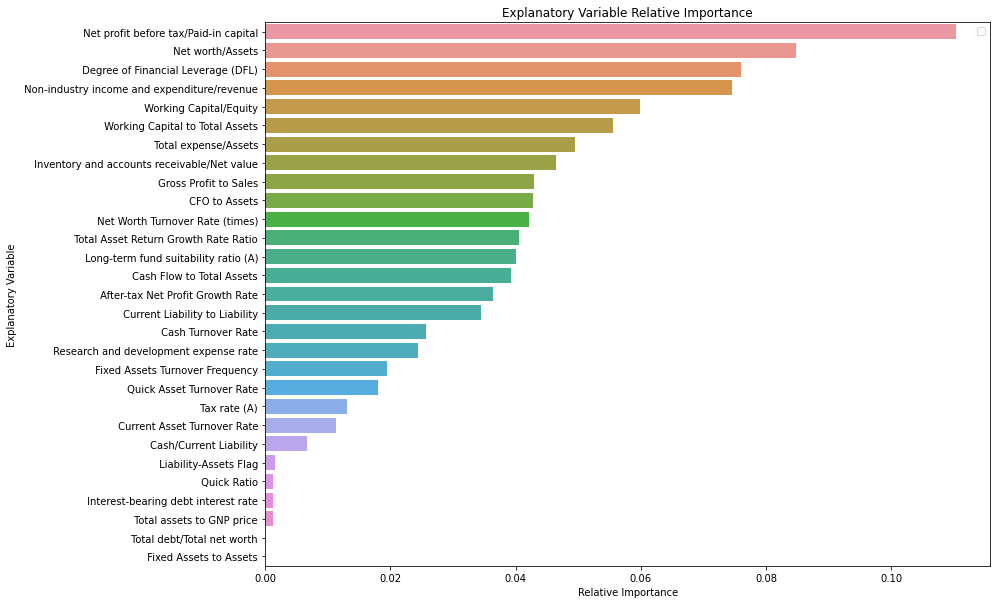

In [ ]:
# creating bar plot
plt.figure(figsize=(13, 10))
sns.barplot(x=featureImportance, y=featureImportance.index)
plt.xlabel('Relative Importance')
plt.ylabel('Explanatory Variable')
plt.title("Explanatory Variable Relative Importance")
plt.legend()
plt.show()

Based upon Relative Importance scores above, eliminate the last 7 explanatory variables

In [10]:
Xdf2 = Xdf.drop(columns=[' Cash/Current Liability', ' Liability-Assets Flag', ' Total debt/Total net worth', ' Quick Ratio',
                         ' Fixed Assets to Assets',' Total assets to GNP price', ' Interest-bearing debt interest rate'])

# split again into training set and validation sets (80:20)
Xtrain, Xval, yTrain, yVal = train_test_split(Xdf2, yDF, test_size=0.20)

Random Forest Hyperparameter tuning, adapted from code at:

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# verify grid parameters
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# use the random grid to search for best hyperparameters

# create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(Xtrain, yTrain)

# view the best parameters obtained from above search:
print('The best parameters obtained from the random search are:\n',rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best parameters obtained from the random search are:
 {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


========================================================================

In [5]:
# function to be used to print out results from RandomSearch and GridSearch
def evaluate(model, test_features, test_labels):
    predictions = model.predict(Xval)
    errors = abs(predictions - yVal)
    mape = 100 * np.mean(errors / yVal)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

============================================================================

In [ ]:
# comparison of Random Search results with initial guess
#  (i.e., did Random Search improve results?)

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(Xtrain, yTrain)
print('Initial starting guess results:')
base_accuracy = evaluate(base_model, Xval, yVal)

# results after RandomSearch
best_random = rf_random.best_estimator_
print('\nResults after RandomSearch:')
random_accuracy = evaluate(best_random, Xval, yVal)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Initial starting guess results:
Model Performance
Average Error: 0.0477 degrees.
Accuracy = -inf%.

Results after RandomSearch:
Model Performance
Average Error: 0.0431 degrees.
Accuracy = -inf%.
Improvement of nan%.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
# improve upon RandomSearch results using GridSearch

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True,False],
    'max_depth': [20],
    'max_features': ['auto','sqrt'],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [1,2,3],
    'n_estimators': [650,800,950]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/pa

GridSearch found the following best parameters:
 {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 650}
Model Performance
Average Error: 0.0433 degrees.
Accuracy = -inf%.
Improvement of nan%.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


Try GridSearch again around best parameters

In [ ]:
# improve upon previous GridSearch results using GridSearch again

# parameter grid
param_grid = {
    'bootstrap': [False],
    'max_depth': [20],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [2,3,4],
    'n_estimators': [650,750]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 18 candidates, totalling 54 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 750}
Model Performance
Average Error: 0.0431.
Accuracy = -inf%.
Improvement of nan%.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [ ]:
# improve upon previous GridSearch results using GridSearch again

# parameter grid 
param_grid = {
    'bootstrap': [False],
    'max_depth': [20],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [3,4,5],
    'n_estimators': [720,750,780]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

NameError: ignored

In [ ]:
# improve upon previous GridSearch results using GridSearch again

# parameter grid
param_grid = {
    'bootstrap': [False],
    'max_depth': [20],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [3,4,5],
    'n_estimators': [700,710,720]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 27 candidates, totalling 81 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 710}
Model Performance
Average Error: 0.0438.
Accuracy = -inf%.


In [ ]:
# improve upon previous GridSearch results using GridSearch again

# parameter grid 
param_grid = {
    'bootstrap': [False],
    'max_depth': [18,20,22],
    'max_features': ['sqrt'],
    'min_samples_leaf': [5],
    'min_samples_split': [2,3],
    'n_estimators': [705,710,715]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 18 candidates, totalling 54 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 715}
Model Performance
Average Error: 0.0438.
Accuracy = -inf%.


In [ ]:
# improve upon previous GridSearch results using GridSearch again

# parameter grid 
param_grid = {
    'bootstrap': [False],
    'max_depth': [22,25,28],
    'max_features': ['sqrt'],
    'min_samples_leaf': [5],
    'min_samples_split': [2,],
    'n_estimators': [715,720,725]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 9 candidates, totalling 27 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 715}
Model Performance
Average Error: 0.0458.
Accuracy = -inf%.


In [ ]:
# improve upon previous GridSearch results using GridSearch again

# parameter grid 
param_grid = {
    'bootstrap': [False],
    'max_depth': [27,28,29],
    'max_features': ['sqrt'],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'n_estimators': [715,720,725]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 9 candidates, totalling 27 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'max_depth': 27, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 725}
Model Performance
Average Error: 0.0463.
Accuracy = -inf%.


In [ ]:
# improve upon previous GridSearch results using GridSearch again

#  parameter grid 
param_grid = {
    'n_estimators': [700,715,730],
    'criterion': ['gini','entropy'],
    'max_depth': [27,28,29],
    'min_samples_split': [2],
    'min_samples_leaf': [3,5,7],
    'max_features': [10,15,20],
    'bootstrap': [False],
}
# Create a based model
rfc = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 162 candidates, totalling 486 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 27, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 715}
Model Performance
Average Error: 0.0286.
Accuracy = -inf%.


In [ ]:
# improve upon previous GridSearch results using GridSearch again

# parameter grid 
param_grid = {
    'n_estimators': [712,715,717],
    'criterion': ['entropy'],
    'max_depth': [26,27,28],
    'min_samples_split': [2],
    'min_samples_leaf': [5],
    'max_features': [8,10,12],
    'bootstrap': [False],
}
# Create a based model
rfc = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 27 candidates, totalling 81 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 26, 'max_features': 8, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 717}
Model Performance
Average Error: 0.0301.
Accuracy = -inf%.


In [ ]:
# improve upon previous GridSearch results using GridSearch again

# parameter grid 
param_grid = {
    'n_estimators': [716,718,720],
    'criterion': ['entropy'],
    'max_depth': [24,25,26],
    'min_samples_split': [2],
    'min_samples_leaf': [5],
    'max_features': [6,8,10],
    'bootstrap': [False],
}
# Create a based model
rfc = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 27 candidates, totalling 81 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 716}
Model Performance
Average Error: 0.0293.
Accuracy = -inf%.


In [ ]:
# improve upon previous GridSearch results using GridSearch again

# parameter grid 
param_grid = {
    'n_estimators': [714,715,716],
    'criterion': ['entropy'],
    'max_depth': [25],
    'min_samples_split': [2],
    'min_samples_leaf': [5],
    'max_features': [8,9,10],
    'bootstrap': [False],
}
# Create RandomForestClassifier model
rfc = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 9 candidates, totalling 27 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 715}
Model Performance
Average Error: 0.0301.
Accuracy = -inf%.


==================================================================================================

**Generate prediction and F1 score using Validation data set and the tuned Random Forest Classifier**

In [14]:
# list the parameters to be used
nEstimators = 715
criterionChoice = 'entropy'
maxDepth = 25
minSamplesSplit = 2
minSamplesLeaf = 5
maxFeatures = 10
bootstrapChoice = False

rfc = RandomForestClassifier(
    n_estimators = nEstimators,
    criterion = criterionChoice,
    max_depth = maxDepth,
    min_samples_split = minSamplesSplit,
    min_samples_leaf = minSamplesLeaf,
    max_features = maxFeatures,
    bootstrap = bootstrapChoice
)

rfcModel = rfc.fit(Xtrain, yTrain)

yTrainPredict = rfcModel.predict(Xtrain)
yValPredict = rfcModel.predict(Xval)

print('\nTraining data f1 score =', metrics.f1_score(yTrain, yTrainPredict))
print('Validation data f1 score =', metrics.f1_score(yVal, yValPredict))


Training data f1 score = 0.9216867469879518
Validation data f1 score = 0.37037037037037035


**Gradient boosted trees**

In [15]:
# list the parameters to be used
nEstimators = 715
maxDepth = 25
minSamplesSplit = 2
minSamplesLeaf = 5
maxFeatures = 10

gbc = GradientBoostingClassifier(n_estimators=nEstimators, max_depth=maxDepth,
                                 min_samples_split=minSamplesSplit,
                                 min_samples_leaf=minSamplesLeaf,
                                 max_features=maxFeatures)

gbcModel = gbc.fit(Xtrain, yTrain)

yTrainPredict_boost = gbcModel.predict(Xtrain)
yValPredict_boost = gbcModel.predict(Xval)

print('\nTraining data f1 score =', metrics.f1_score(yTrain, yTrainPredict_boost))
print('Validation data f1 score =', metrics.f1_score(yVal, yValPredict_boost))


Training data f1 score = 1.0
Validation data f1 score = 0.2545454545454546


**Extra Trees Classifier**

In [22]:
# initially use Grid Search to tune hyperparameters

# parameter grid 
param_grid = {
    'n_estimators': [400,800],
    'criterion' : ['gini','entropy'],
    'max_depth' : [10,20,25],
    'min_samples_split' : [2,5],
    'min_samples_leaf' : [2,5],
    'max_features': ['sqrt','log2', None],
    'bootstrap': [False]
}

# create Extra Trees Classifier
etc = ExtraTreesClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = etc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [23]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)

Fitting 3 folds for each of 144 candidates, totalling 432 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
Model Performance
Average Error: 0.0411.
Accuracy = -inf%.


In [24]:
# use previous Grid Search results to re-perform Grid Search again

# parameter grid 
param_grid = {
    'n_estimators': [200,400,500],
    'criterion' : ['gini','entropy'],
    'max_depth' : [18,20,22],
    'min_samples_split' : [1,2,3],
    'min_samples_leaf' : [1,2,3],
    'max_features': [None],
    'bootstrap': [False]
}

# create Extra Trees Classifier
etc = ExtraTreesClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = etc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [25]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
162 fits failed out of a total of 486.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/p


GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 22, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
Model Performance
Average Error: 0.0403.
Accuracy = -inf%.


In [26]:
# use previous Grid Search results to re-perform Grid Search again

# parameter grid 
param_grid = {
    'n_estimators': [150,200,250],
    'criterion' : ['gini','entropy'],
    'max_depth' : [20,22,24],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' : [1,2],
    'max_features': [None],
    'bootstrap': [False]
}

# create Extra Trees Classifier
etc = ExtraTreesClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = etc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [27]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)

Fitting 3 folds for each of 108 candidates, totalling 324 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 24, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 250}
Model Performance
Average Error: 0.0411.
Accuracy = -inf%.


In [30]:
# use previous Grid Search results to re-perform Grid Search again

# parameter grid 
param_grid = {
    'n_estimators': [300,400,500],
    'criterion' : ['gini','entropy'],
    'max_depth' : [22,24,26],
    'min_samples_split' : [3,4,5],
    'min_samples_leaf' : [2,3],
    'max_features': [None],
    'bootstrap': [False]
}

# create Extra Trees Classifier
etc = ExtraTreesClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = etc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [31]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)

Fitting 3 folds for each of 108 candidates, totalling 324 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 26, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300}
Model Performance
Average Error: 0.0411.
Accuracy = -inf%.


In [32]:
# use previous Grid Search results to re-perform Grid Search again

# parameter grid 
param_grid = {
    'n_estimators': [230,265,300],
    'criterion' : ['gini','entropy'],
    'max_depth' : [25,26,27,28],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' : [2],
    'max_features': [None],
    'bootstrap': [False]
}

# create Extra Trees Classifier
etc = ExtraTreesClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = etc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [33]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)

Fitting 3 folds for each of 72 candidates, totalling 216 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Model Performance
Average Error: 0.0389.
Accuracy = -inf%.


In [35]:
# use previous Grid Search results to re-perform Grid Search again

# parameter grid 
param_grid = {
    'n_estimators': [280,300,350],
    'criterion' : ['gini','entropy'],
    'max_depth' : [24,25,26],
    'min_samples_split' : [2],
    'min_samples_leaf' : [2],
    'max_features': [None],
    'bootstrap': [False]
}

# create Extra Trees Classifier
etc = ExtraTreesClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = etc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [36]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)

Fitting 3 folds for each of 18 candidates, totalling 54 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 26, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 280}
Model Performance
Average Error: 0.0403.
Accuracy = -inf%.


In [37]:
# use previous Grid Search results to re-perform Grid Search again

# parameter grid 
param_grid = {
    'n_estimators': [260,280,300],
    'criterion' : ['gini','entropy'],
    'max_depth' : [25,26,27],
    'min_samples_split' : [2],
    'min_samples_leaf' : [2],
    'max_features': [None],
    'bootstrap': [False]
}

# create Extra Trees Classifier
etc = ExtraTreesClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = etc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [38]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)

Fitting 3 folds for each of 18 candidates, totalling 54 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 26, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 280}
Model Performance
Average Error: 0.0403.
Accuracy = -inf%.


In [39]:
# use previous Grid Search results to re-perform Grid Search again

# parameter grid 
param_grid = {
    'n_estimators': [270,275,280,285,290],
    'criterion' : ['entropy'],
    'max_depth' : [26],
    'min_samples_split' : [2],
    'min_samples_leaf' : [2],
    'max_features': [None],
    'bootstrap': [False]
}

# create Extra Trees Classifier
etc = ExtraTreesClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = etc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [40]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 26, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 280}
Model Performance
Average Error: 0.0403.
Accuracy = -inf%.


In [42]:
# use previous Grid Search results to re-perform Grid Search again

# parameter grid 
param_grid = {
    'n_estimators': [278,279,280,281,282],
    'criterion' : ['entropy'],
    'max_depth' : [26],
    'min_samples_split' : [2],
    'min_samples_leaf' : [2],
    'max_features': [None],
    'bootstrap': [False]
}

# create Extra Trees Classifier
etc = ExtraTreesClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = etc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [43]:
# Fit the grid search to the data
grid_search.fit(Xtrain, yTrain)
print('\nGridSearch found the following best parameters:\n', grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xval, yVal)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

GridSearch found the following best parameters:
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 26, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 281}
Model Performance
Average Error: 0.0403.
Accuracy = -inf%.


In [46]:
# list the parameters to be used
nEstimators = 281
criterionChoice = 'entropy'
maxDepth = 26
minSamplesSplit = 2
minSamplesLeaf = 2
maxFeatures = None
bootstrapChoice = False

# create Extra Trees Classifier
etc = ExtraTreesClassifier(n_estimators=nEstimators, criterion=criterionChoice, max_depth=maxDepth,
                           min_samples_split=minSamplesSplit, min_samples_leaf=minSamplesLeaf,
                           max_features=maxFeatures, bootstrap=bootstrapChoice)

etcModel = etc.fit(Xtrain, yTrain)

yTrainPredict = etcModel.predict(Xtrain)
yValPredict = etcModel.predict(Xval)

print('\nTraining data f1 score =', metrics.f1_score(yTrain, yTrainPredict))
print('Validation data f1 score =', metrics.f1_score(yVal, yValPredict))


Training data f1 score = 0.9969418960244648
Validation data f1 score = 0.2571428571428572


# SUMMARY / REFLECTION

The EDA for this assignment was largely performed in the previous Assignment for Week 4.  In hindsight, rather than start with the results from the previous assignment, a new EDA (from scratch) may have been worthwhile.

For example, after basic boxplot and correlation heatmap evaluations, the use of a random grid, with RandomizedSearchCV() could have been used on a larger set of explanatory variables/features to perform initial hyperparameter tuning. 
The best parameters from initial hyperparameter tuning could be used to fit a random forest (using RandomForestClassifier().fit).  Then, feature Importances (using the RandomForestClassifier().feature_importances_) could be obtained, and these could be used to perform initial pruning of the features.

After initial hyperparameter tuning with RandomizedSearchCV(), feature importance ranking with RandomForestClassifier().feature_importances_, and initial pruning of features, additional iterations of hyperparameter tuning and feature pruning could be performed using GridSearchCV() and evaluating feature importances using RandomForestClassifier().feature_importances_.

As a summary of the classification results obtained in this assignment, the following f1 scores were obtained:



**Random Forest Classifier**

Training data f1 score = 0.9216867469879518

Validation data f1 score = 0.37037037037037035

**Gradient boosted trees**

Training data f1 score = 1.0

Validation data f1 score = 0.2545454545454546

**Extra Trees Classifier**

Training data f1 score = 0.9969418960244648

Validation data f1 score = 0.2571428571428572

As the results above show, prediction results using the training data were very good, but prediction results for the validation set were poor.  As mentioned above, it might have been helpful to perform a new EDA from scratch using the approach described above (i.e., perform iterative hyperparameter tuning with pruning using feature importances), rather than rely so heavily on the EDA from the previous Assignment #4.